# Classification with a Tabular Vector Borne Disease Dataset

## Useful Links
### Competition & Original Dataset
- https://www.kaggle.com/competitions/playground-series-s3e13
- (Optional, Original Dataset Link) https://www.kaggle.com/datasets/richardbernat/vector-borne-disease-prediction

### Reference Notebooks
- https://www.kaggle.com/code/sergiosaharovskiy/ps-s3e13-2023-eda-and-submission
- https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code
- https://www.kaggle.com/code/wlifferth/generating-map-k-predictions
- https://www.kaggle.com/code/francescoliveras/ps-s3-e13-eda-model-en-es

## Exploratory Data Analysis
### Load Libraries

In [1]:
from collections import Counter
import json
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

### Download Data
#### Generate `kaggle.json` for data download
Ref: [Kaggle API Docs](https://www.kaggle.com/docs/api#getting-started-installation-&-authentication)
1. Go to https://www.kaggle.com/settings.
2. Clik [Create New Token].
3. Open downloaded `kaggle.json`.

In [2]:
# Paste your kaggle.json below!
key = {"username":"my_username","key":"asdf3asdf442345asd453134ajjkskja"}

In [3]:
# If you use google colab, execute the code below.
Path('/root/.kaggle').mkdir(parents=True, exist_ok=True)
with Path('/root/.kaggle/kaggle.json').open('w') as f:
    json.dump(key, f)

# If not, save kaggle.json into ~/.kaggle/kaggle.json

In [4]:
# Download synthetically generated dataset for competition
!kaggle competitions download -c playground-series-s3e13
!unzip -o playground-series-s3e13.zip

# Download original dataset for analysis
!kaggle datasets download -d richardbernat/vector-borne-disease-prediction
!unzip -o vector-borne-disease-prediction.zip

playground-series-s3e13.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  playground-series-s3e13.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
vector-borne-disease-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  vector-borne-disease-prediction.zip
  inflating: testt.csv               
  inflating: trainn.csv              


### Load Data

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


In [6]:
train_origin_df = pd.read_csv('trainn.csv')
test_origin_df = pd.read_csv('testt.csv')
train_origin_df.head()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Chikungunya
1,1,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,Chikungunya
2,0,1,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,Chikungunya
3,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,Chikungunya
4,1,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,Chikungunya


In [7]:
# Encoder our prognosis labels as integers for easier decoding later
target_col = 'prognosis'
enc = OrdinalEncoder()
enc.fit(train_df[[target_col]])

OrdinalEncoder()

In [8]:
enc.categories_

[array(['Chikungunya', 'Dengue', 'Japanese_encephalitis', 'Lyme_disease',
        'Malaria', 'Plague', 'Rift_Valley_fever', 'Tungiasis',
        'West_Nile_fever', 'Yellow_Fever', 'Zika'], dtype=object)]

In [9]:
Counter(train_df[target_col])

Counter({'Lyme_disease': 52,
         'Tungiasis': 70,
         'Zika': 58,
         'Rift_Valley_fever': 70,
         'West_Nile_fever': 85,
         'Malaria': 48,
         'Chikungunya': 66,
         'Plague': 53,
         'Dengue': 63,
         'Yellow_Fever': 61,
         'Japanese_encephalitis': 81})

### Visualize Feature Correlation

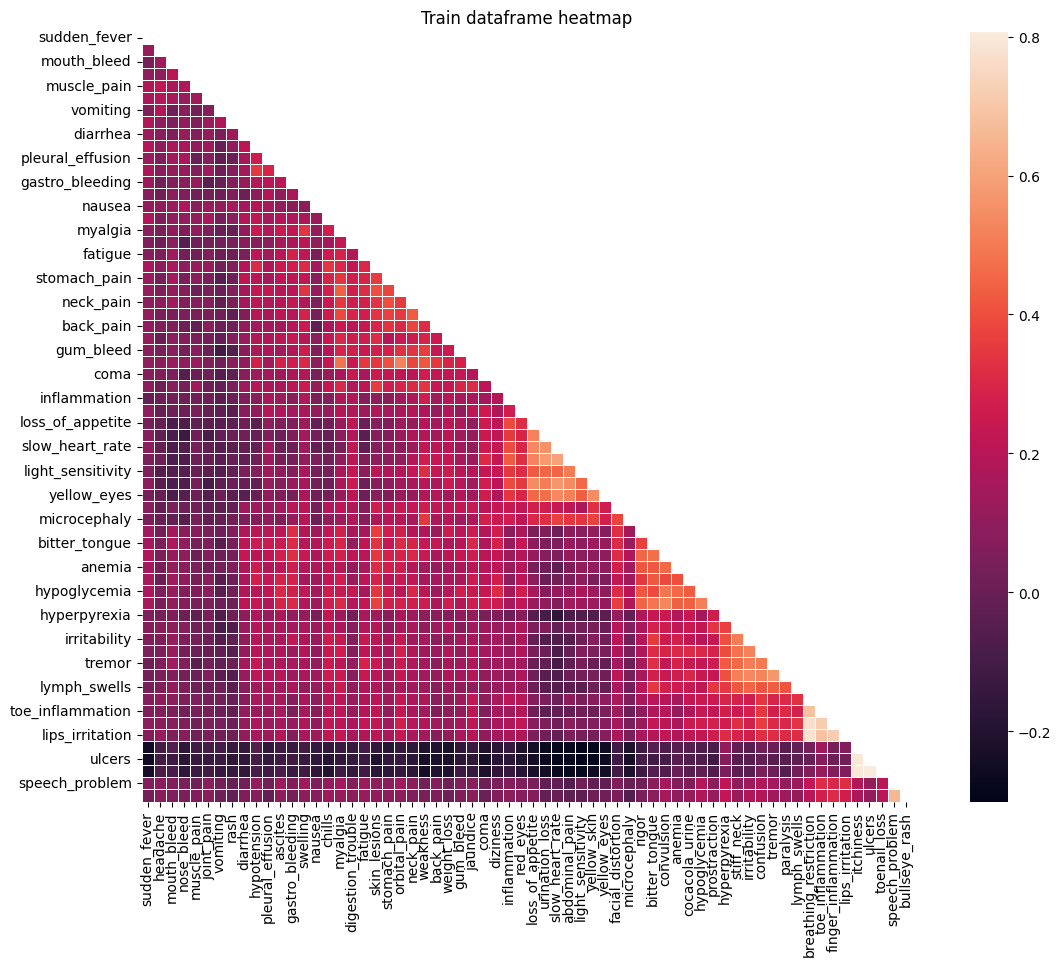

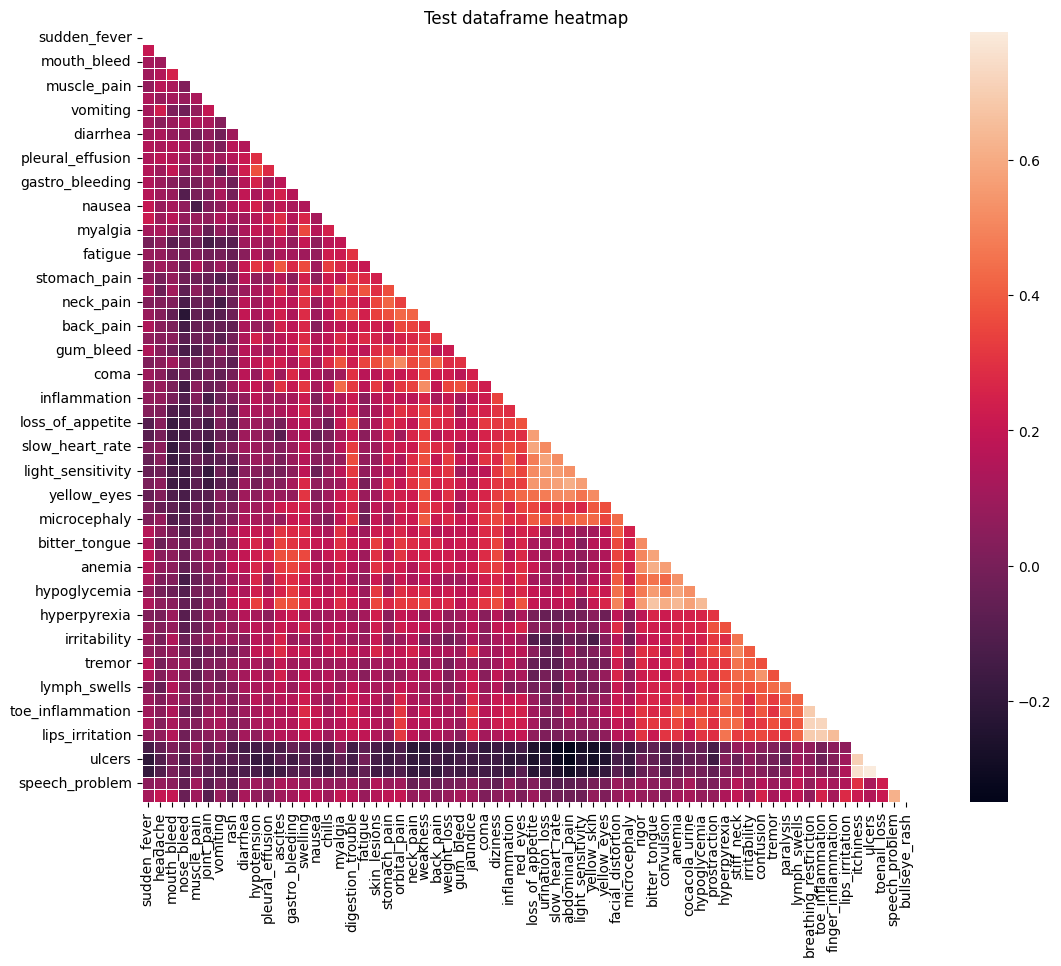

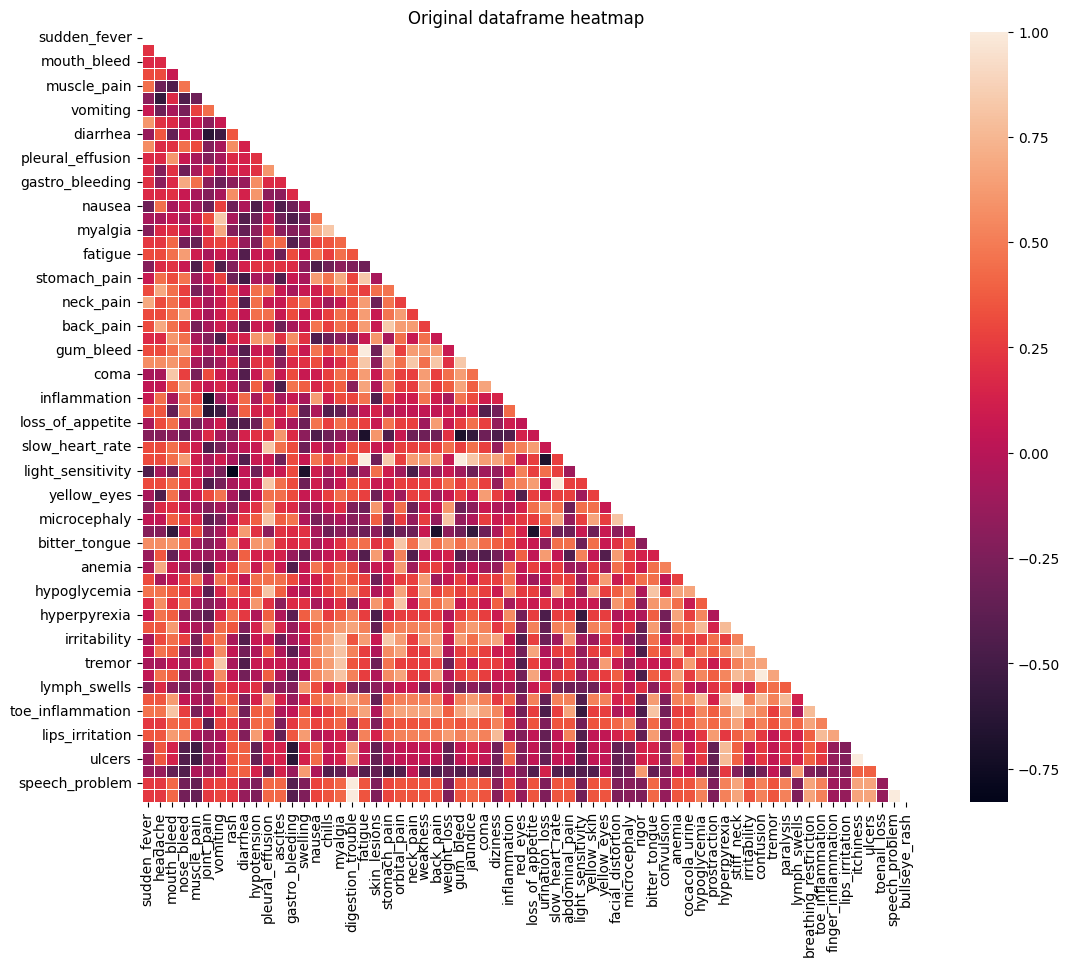

In [10]:
def show_corr_heatmap(df, title):
    drop_columns = list({'id', target_col} & set(df.columns))
    df = df.drop(columns=drop_columns)
    corr = df.corr(numeric_only=False)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(title)
    sns.heatmap(corr, annot=False, linewidths=0.5, fmt='.2f', square=True, mask=mask, ax=ax)
    plt.show()

show_corr_heatmap(train_df, 'Train dataframe heatmap')
show_corr_heatmap(test_df, 'Test dataframe heatmap')
show_corr_heatmap(test_origin_df, 'Original dataframe heatmap')

### Kernel Density Estimate (KDE) Plot

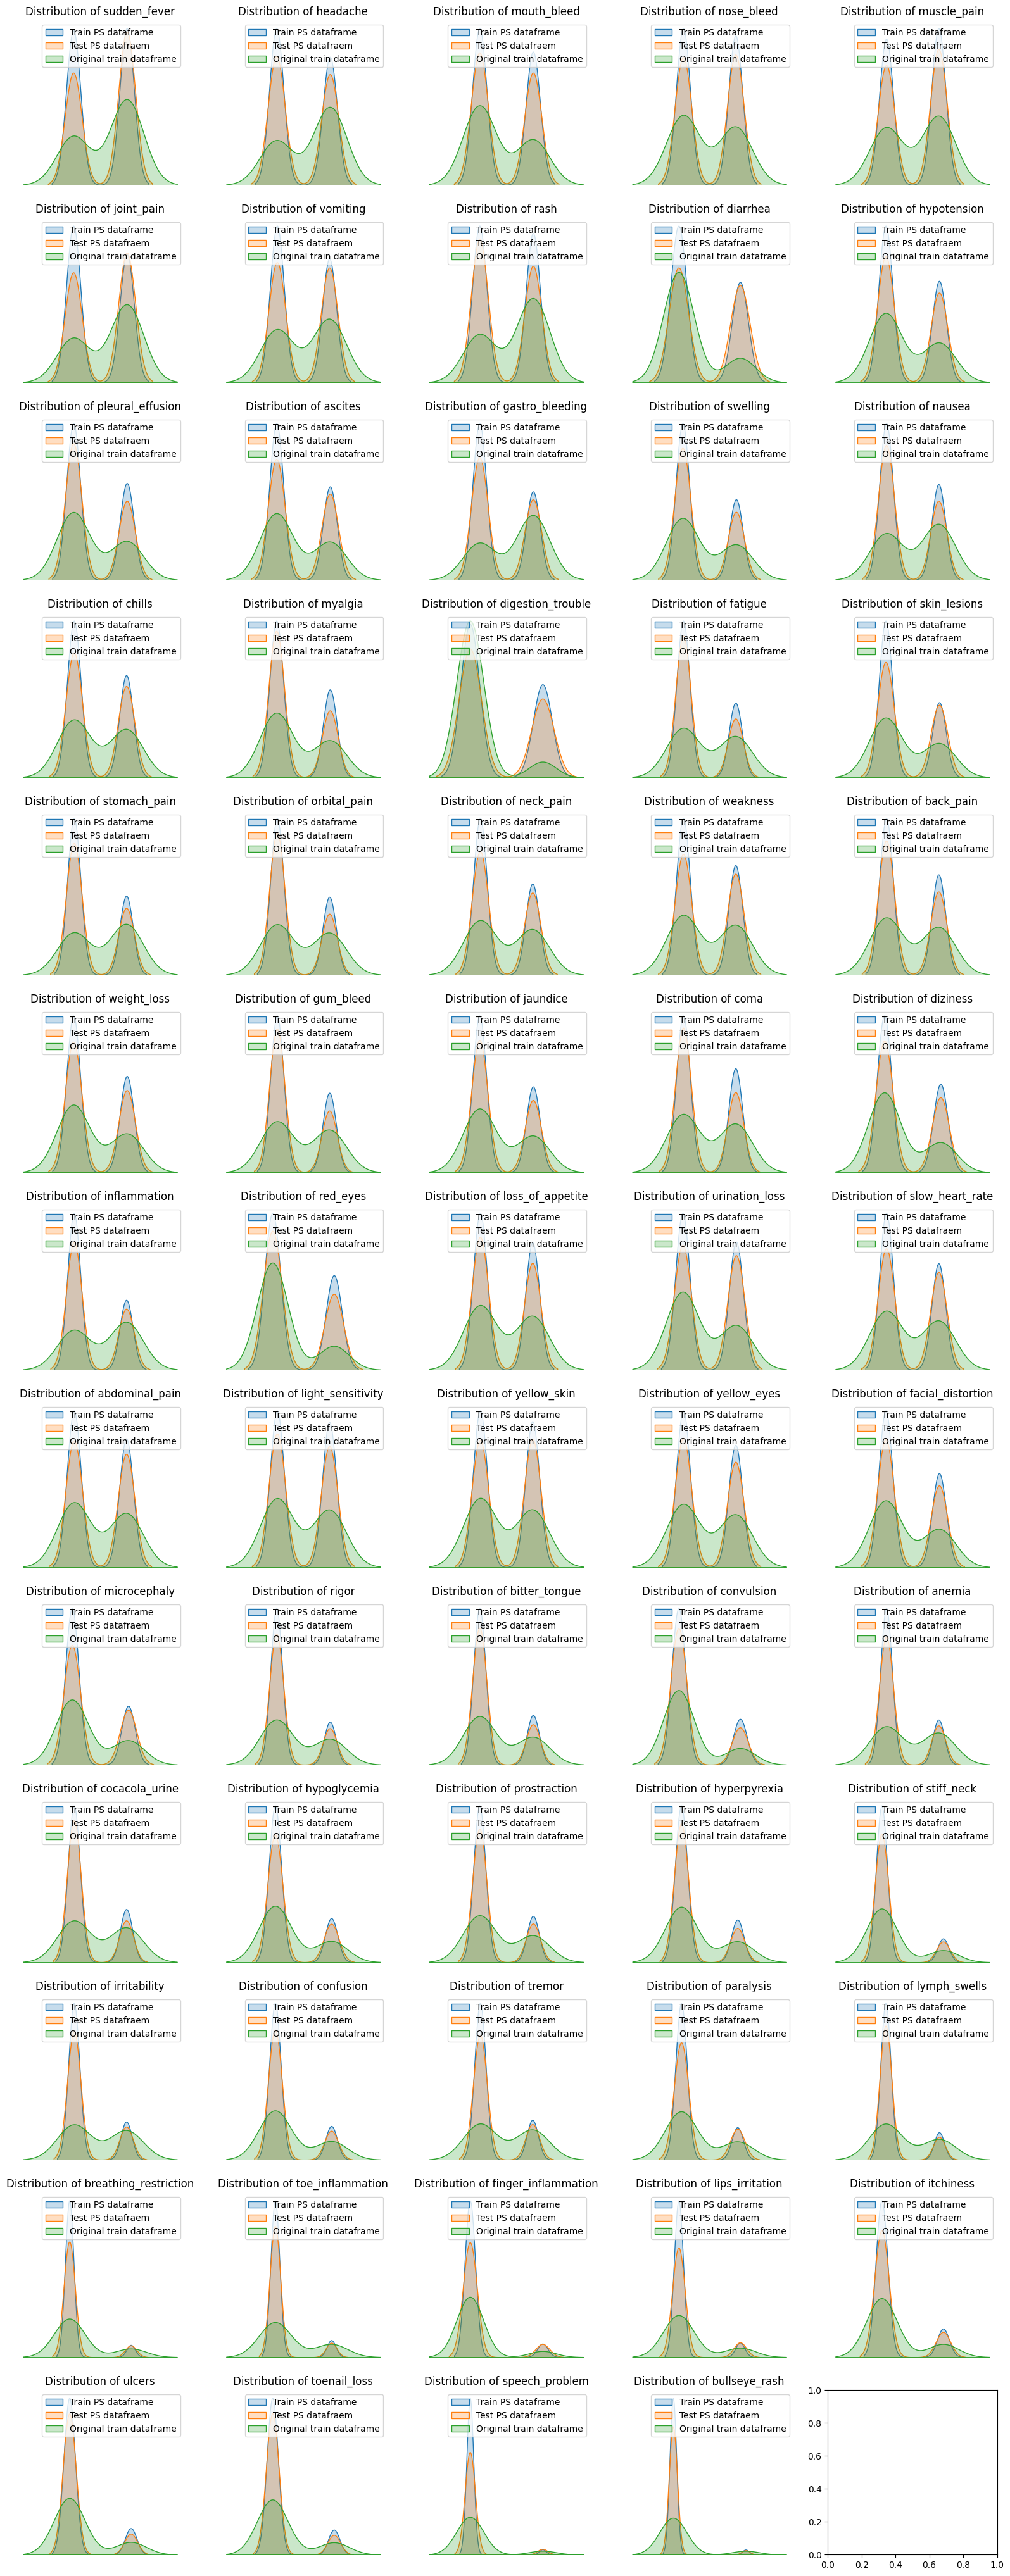

In [11]:
columns = [col
           for col in test_df.columns
           if col not in ['id', target_col]]

ncols = 5
nrows = math.ceil(len(columns) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows*4))
ax = axes.flatten()

for i, col in enumerate(columns):
    sns.kdeplot(
        train_df[col], label='Train PS dataframe',
        ax=ax[i], fill=True)

    sns.kdeplot(
        test_df[col], label='Test PS datafraem',
        ax=ax[i], fill=True)

    sns.kdeplot(
        test_origin_df[col], label='Original train dataframe',
        ax=ax[i], fill=True)

    # titles
    ax[i].set_title(f'Distribution of {col}');
    ax[i].set_xlabel(None)
    ax[i].axis('off')
    ax[i].legend()

plt.show()

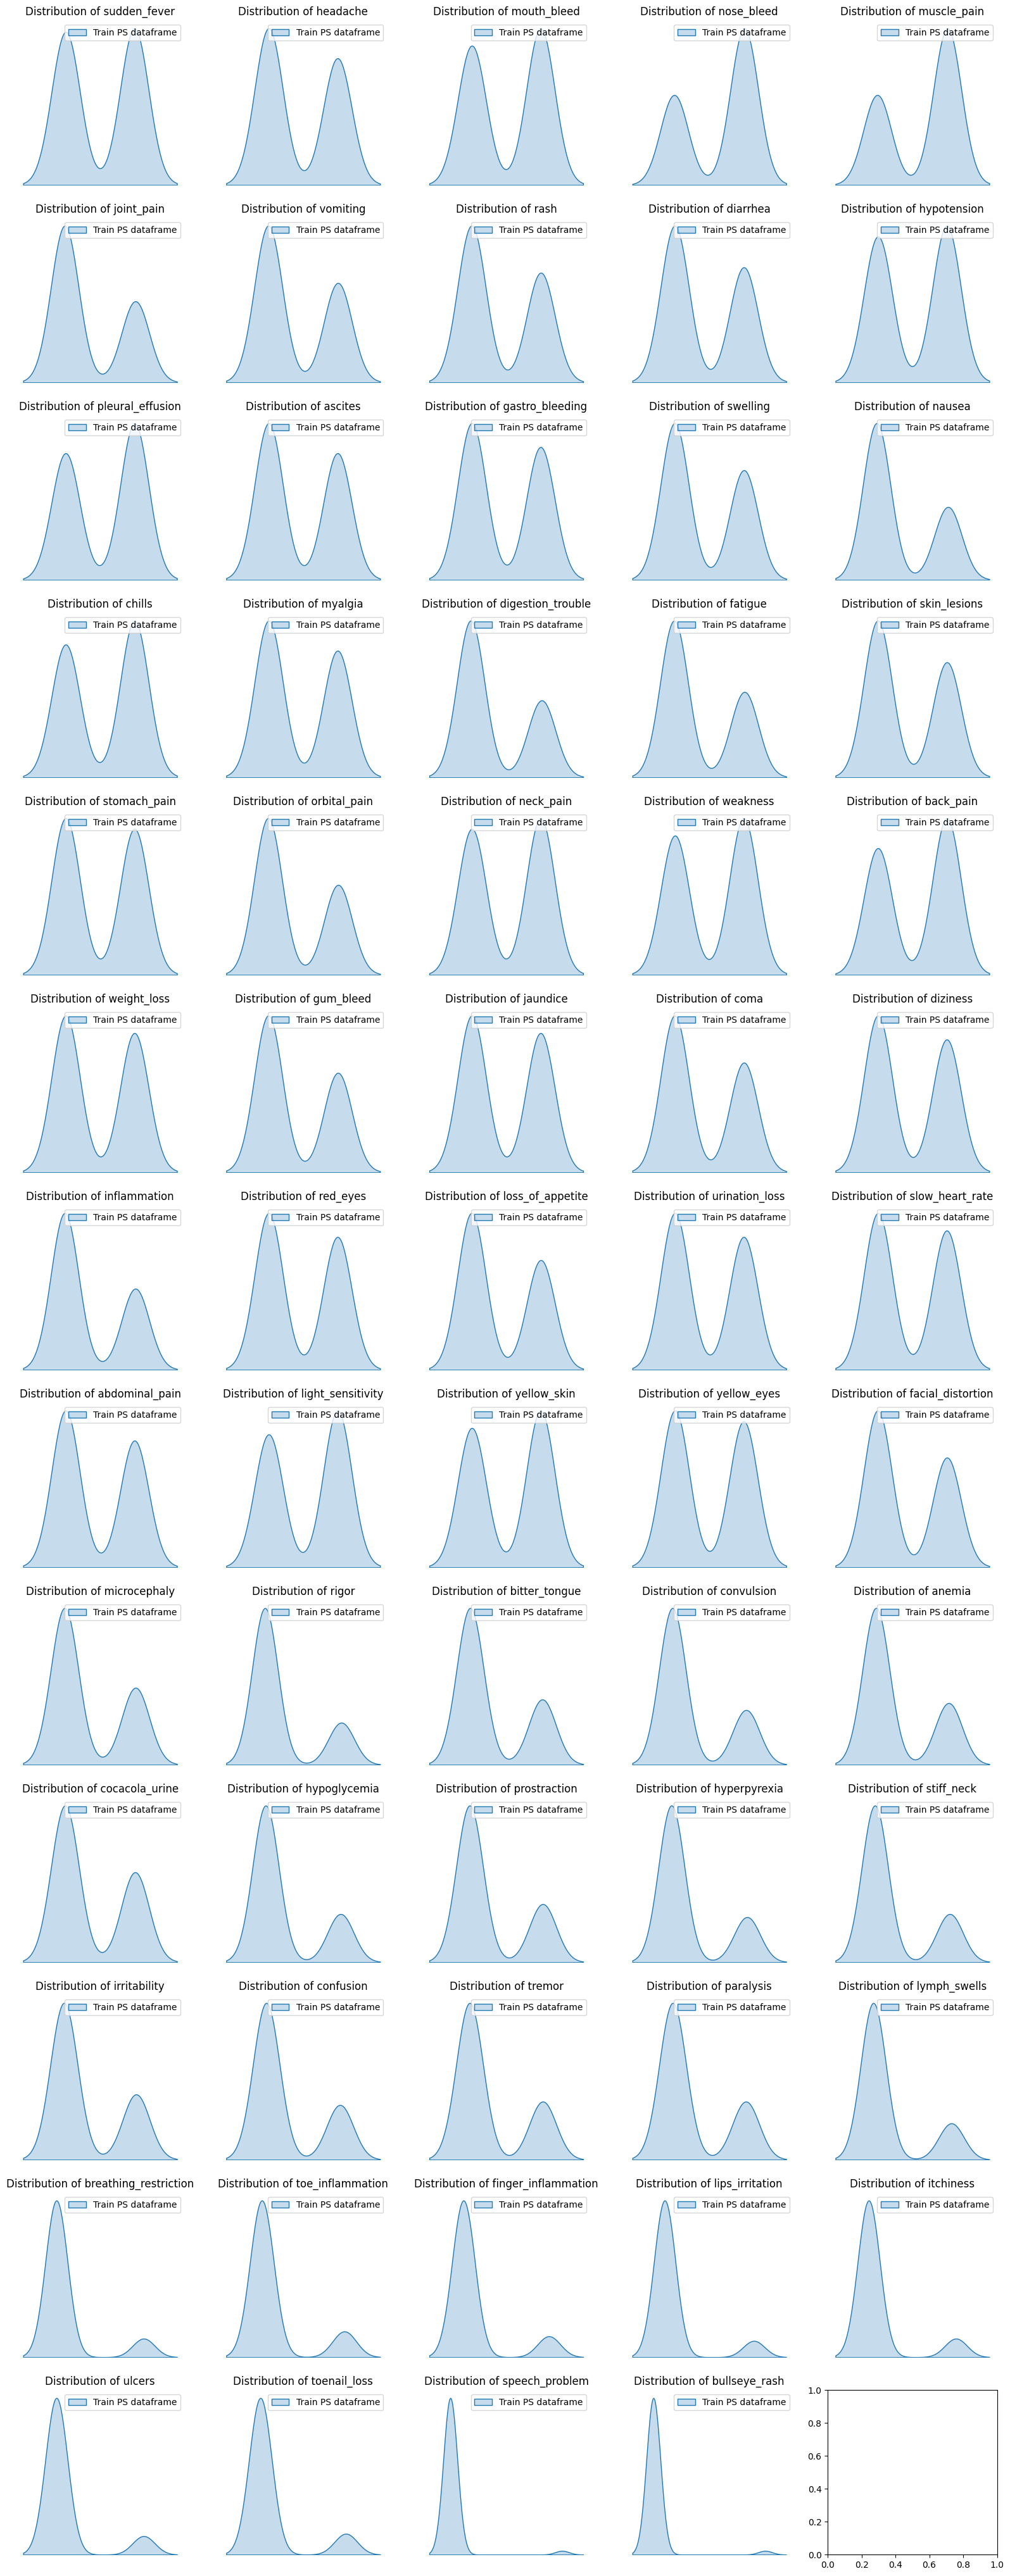

In [12]:
target_disease = 'West_Nile_fever'
disease_df = train_df[train_df[target_col] == target_disease]

fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows*4))
ax = axes.flatten()

for i, col in enumerate(columns):
    sns.kdeplot(
        disease_df[col], label='Train PS dataframe',
        ax=ax[i], fill=True)

    # titles
    ax[i].set_title(f'Distribution of {col}');
    ax[i].set_xlabel(None)
    ax[i].axis('off')
    ax[i].legend()

plt.show()

## Training a logistic regression model and predicting probabilities


In [13]:
X = train_df.drop(columns=['id', target_col]).values
Y = enc.transform(train_df[[target_col]]).reshape(-1).astype(int)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, random_state=42)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(530, 64) (177, 64) (530,) (177,)


In [14]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, Y_train)

Y_prob = lr_clf.predict_proba(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Generating Top K for a single row

In [15]:
# Lets take a look at getting our top 3 prognoses for just a single prediction first
print('First sample output of predict_proba:')
print(Y_prob[0])

First sample output of predict_proba:
[0.22216378 0.30095801 0.34934614 0.00061231 0.0096512  0.00147735
 0.01520866 0.01124576 0.00319603 0.07571885 0.01042193]


In [16]:
# We can get the indices of the highest probabilities with argsort
sorted_prediction_ids = np.argsort(-Y_prob[0])  # descending order

print("Indices sorted by probabilities:")
print(sorted_prediction_ids)
# 2 is our first id, and the probability at index 2 from Y_prob[0] is the highest (0.30095801)

Indices sorted by probabilities:
[ 2  1  0  9  6  7 10  4  8  5  3]


In [17]:
# We can grab the top 3 predictions and then use our encoder to turn them back into string labels
top_3_prediction_ids = sorted_prediction_ids[:3]
enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1))

array([['Japanese_encephalitis'],
       ['Dengue'],
       ['Chikungunya']], dtype=object)

### Calculating AP@K on a single row

In [18]:
# https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook
def apk(actual, predicted, k):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(actual), k)

In [19]:
Y_val[0]

1

In [20]:
apk([Y_val[0]], top_3_prediction_ids, 3)

0.5

### Generating Top K for all rows

In [21]:
# Now let's look at doing the above for a whole set of predictions at once:
sorted_prediction_ids = np.argsort(-Y_prob, axis=1)
top_3_prediction_ids = sorted_prediction_ids[:,:3]

# Because enc.inverse_transform expects a specific shape (a 2D array with 1 column) we can save the original shape to reshape to after decoding
enc.inverse_transform(top_3_prediction_ids.reshape(-1, 1)).reshape(-1, 3)[:10]

array([['Japanese_encephalitis', 'Dengue', 'Chikungunya'],
       ['West_Nile_fever', 'Tungiasis', 'Japanese_encephalitis'],
       ['Rift_Valley_fever', 'West_Nile_fever', 'Dengue'],
       ['Zika', 'Tungiasis', 'Japanese_encephalitis'],
       ['Tungiasis', 'Dengue', 'Chikungunya'],
       ['Tungiasis', 'Dengue', 'Rift_Valley_fever'],
       ['West_Nile_fever', 'Plague', 'Japanese_encephalitis'],
       ['Japanese_encephalitis', 'Dengue', 'Rift_Valley_fever'],
       ['Dengue', 'Chikungunya', 'Rift_Valley_fever'],
       ['Zika', 'Tungiasis', 'Yellow_Fever']], dtype=object)

### Calculating MAP@K on our validation set
So now we have our top K(=3) predictions, but what is our MAP@K?
To calculate this we'll use the mapk function from the ml_metrics library. The function is pasted below to avoid having to install the package.

In [22]:
# https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook
def mapk(actual, predicted, k):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [23]:
mapk(Y_val.reshape(-1, 1), top_3_prediction_ids, 3)

0.3003766478342749

## Generating Test Predictions


In [24]:
test_df.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,708,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,709,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,710,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,711,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
Y_prob = lr_clf.predict_proba(test_df.drop(columns=['id']))
Y_k_pred = enc.inverse_transform(np.argsort(-Y_prob)[:, :3].reshape(-1, 1)).reshape(-1, 3)

submission_df = pd.DataFrame(
    index=test_df['id'], columns=[target_col],
    data=np.apply_along_axis(lambda x: np.array(' '.join(x), dtype="object"), 1, Y_k_pred))
submission_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,prognosis
id,
707,Rift_Valley_fever Tungiasis Zika
708,Dengue Malaria Chikungunya
709,West_Nile_fever Japanese_encephalitis Malaria
710,Japanese_encephalitis Rift_Valley_fever Malaria
711,West_Nile_fever Japanese_encephalitis Plague


In [26]:
submission_df.to_csv('submission.csv')

In [27]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Generate a Boosting Tree Model

In [28]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, Y_train)
Y_prob = xgb_clf.predict_proba(X_val)
Y_k_pred = np.argsort(-Y_prob, axis=1)[:,:3]
print(mapk(Y_val.reshape(-1, 1), Y_k_pred, k=3))

0.33992467043314506


In [29]:
def mapk_score(Y_true, Y_prob, k=3):
    sorted_prob_ids = np.argsort(-Y_prob, axis=1)
    Y_k_pred = sorted_prob_ids[:,:k]
    return mapk(Y_true.reshape(-1, 1), Y_k_pred, k)


mapk_scorer = make_scorer(mapk_score, greater_is_better=True, needs_proba=True)
scores = cross_val_score(XGBClassifier(), X_train, Y_train, scoring=mapk_scorer)
print(f'MAP@3: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})')

MAP@3: 0.3233 (+/- 0.0286)
